In [89]:
import matplotlib.pyplot as plt
import os
import numpy as np
import warnings
warnings.simplefilter("ignore", UserWarning)
import librosa
import librosa.display
import random as rn
import pandas as pd
import IPython.display as ipd
from scipy.io import wavfile
from collections import defaultdict, Counter
from scipy import signal
from statistics import mean 
from keras.layers import Dense
from keras import Input
from keras.engine import Model
from keras.utils import to_categorical
from keras.layers import Dense, TimeDistributed, Dropout, Bidirectional, GRU, BatchNormalization, Activation, LeakyReLU, \
    LSTM, Flatten, RepeatVector, Permute, Multiply, Conv2D, MaxPooling2D


In [71]:
# import data
DATA_DIR = 'recordings/'
SAMPLE_RATE = 22050
NUM_DATA_THRESH = 20
NUM_CLASSES = 3
duration = 4
n_mfcc = 20 # the number of mfcc features
n_mels = 128 # the number of log mel-spectogram features

df = pd.read_csv('speakers_all.csv')
# head_list = df.columns[:-3]
# print('head_list: ', head_list)
language_list = df.groupby('native_language')['native_language'].describe().sort_values(by= ['count'], ascending=False)
language_list = language_list[language_list['count'] > NUM_DATA_THRESH]
print(language_list)
language_list = language_list['top'].to_list()
print('The list of languages: ', language_list) # list of language that has more than 20 data sets
print('The number of different languages: ', len(language_list))


# audio file sorting conditions
language_name = language_list[0]
file_check = False
sex = 'male'

cond1 = df['native_language'] == language_name
cond2 = df['file_missing?'] == file_check
cond3 = df['sex'] == sex

filename = df[cond1 & cond2 & cond3]['filename'].to_numpy()
fname = DATA_DIR + filename[3] + '.mp3'
y, sr = librosa.load(fname, sr = SAMPLE_RATE, duration = duration)
mfcc = librosa.feature.mfcc(y = y, sr = SAMPLE_RATE, n_mfcc = n_mfcc)
melspec = librosa.feature.melspectrogram(y, sr, n_mels = n_mels)
melspec_log = librosa.amplitude_to_db(melspec)

                count unique         top freq
native_language                              
english           579      1     english  579
spanish           162      1     spanish  162
arabic            102      1      arabic  102
mandarin           65      1    mandarin   65
french             63      1      french   63
korean             52      1      korean   52
russian            48      1     russian   48
portuguese         48      1  portuguese   48
dutch              47      1       dutch   47
turkish            37      1     turkish   37
german             36      1      german   36
polish             34      1      polish   34
italian            33      1     italian   33
japanese           27      1    japanese   27
macedonian         26      1  macedonian   26
cantonese          23      1   cantonese   23
farsi              23      1       farsi   23
vietnamese         22      1  vietnamese   22
The list of languages:  ['english', 'spanish', 'arabic', 'mandarin', 'french', '

/Users/jihan/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [72]:
ipd.Audio(y, rate = sr)

<function matplotlib.pyplot.colorbar(mappable=None, cax=None, ax=None, **kw)>

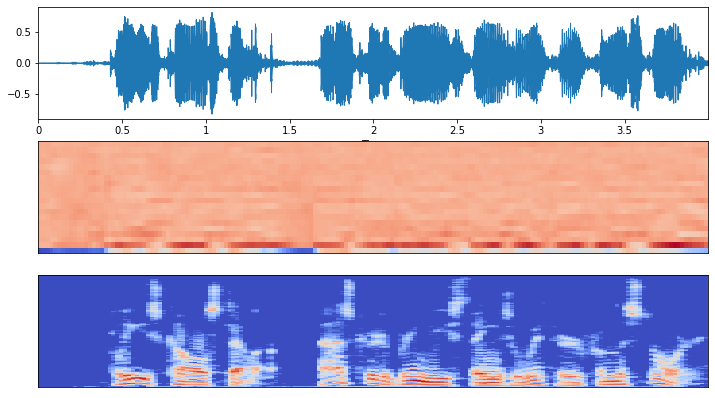

In [73]:
figsize = (12,7)
plt.figure(figsize = figsize)
plt.subplot(3,1,1)
librosa.display.waveplot(y, sr = sr)
plt.subplot(3,1,2)
librosa.display.specshow(mfcc)
plt.subplot(3,1,3)
librosa.display.specshow(melspec_log)
plt.colorbar

In [102]:
DATA_DIR = 'recordings/'
SAMPLE_RATE = 22050
NUM_DATA_THRESH = 20
NUM_CLASSES = 3
duration = 4
n_mfcc = 20 # the number of mfcc features
n_mels = 128 # the number of log mel-spectogram features
file_check = False
sex = 'male'

fname = []
train_X = []
test_X = []
train_Y = []
test_Y = []

for i in range(0,NUM_CLASSES):
    language_name = language_list[i]
    cond1 = df['native_language'] == language_name
    cond2 = df['file_missing?'] == file_check
#     cond3 = df['sex'] == sex
#     filename = df[cond1 & cond2 & cond3]['filename'].to_numpy()
    filename = df[cond1 & cond2]['filename'].to_numpy()
    for count in range(0,100):
        fname = DATA_DIR + filename[count] + '.mp3'
        
        y, sr = librosa.load(fname, sr = SAMPLE_RATE, duration = duration)
        melspec = librosa.feature.melspectrogram(y, sr, n_mels = n_mels)
        melspec_log = librosa.amplitude_to_db(melspec)
        if count < 80:
            train_X.append(melspec_log)
            train_Y.append(i)
        else:
            test_X.append(melspec_log)
            test_Y.append(i)

train_X = np.array(train_X)
train_Y = to_categorical(np.array(train_Y))
test_X = np.array(test_X)
test_Y = to_categorical(np.array(test_Y))
print('train_X:', train_X.shape)
print('train_Y:', train_Y.shape)
print('test_X:', test_X.shape)
print('test_Y:', test_Y.shape)

train_X: (240, 128, 173)
train_Y: (240, 3)
test_X: (60, 128, 173)
test_Y: (60, 3)


In [122]:
NUM_CLASSES = 3

train_X_ex = np.expand_dims(train_X, -1)
test_X_ex = np.expand_dims(test_X, -1)

ip = Input(shape=(train_X_ex[0].shape))
m = Conv2D(32, kernel_size=(4, 4), activation='relu', padding='same')(ip)
m = MaxPooling2D(pool_size=(4, 4))(m)
m = Dropout(0.2)(m)
m = Conv2D(64, kernel_size=(4, 4), activation='relu')(ip)
m = MaxPooling2D(pool_size=(4, 4))(m)
m = Dropout(0.2)(m)
m = Flatten()(m)
m = Dense(32, activation='relu')(m)
op = Dense(NUM_CLASSES, activation='softmax')(m)
model = Model(input=ip, output=op)
model.summary()

# def residual_block(x, filters, conv_num=3, activation="relu"):
#     # Shortcut
#     s = keras.layers.Conv1D(filters, 1, padding="same")(x)
#     for i in range(conv_num - 1):
#         x = keras.layers.Conv1D(filters, 3, padding="same")(x)
#         x = keras.layers.Activation(activation)(x)
#     x = keras.layers.Conv1D(filters, 3, padding="same")(x)
#     x = keras.layers.Add()([x, s])
#     x = keras.layers.Activation(activation)(x)
#     return keras.layers.MaxPool1D(pool_size=2, strides=2)(x)


# def build_model(input_shape, num_classes):
#     inputs = keras.layers.Input(shape=input_shape, name="input")

#     x = residual_block(inputs, 16, 2)
#     x = residual_block(x, 32, 2)
#     x = residual_block(x, 64, 3)
#     x = residual_block(x, 128, 3)
#     x = residual_block(x, 128, 3)

#     x = keras.layers.AveragePooling1D(pool_size=3, strides=3)(x)
#     x = keras.layers.Flatten()(x)
#     x = keras.layers.Dense(256, activation="relu")(x)
#     x = keras.layers.Dense(128, activation="relu")(x)

#     outputs = keras.layers.Dense(num_classes, activation="softmax", name="output")(x)

#     return keras.models.Model(inputs=inputs, outputs=outputs)


Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 128, 173, 1)       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 125, 170, 64)      1088      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 31, 42, 64)        0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 31, 42, 64)        0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 83328)             0         
_________________________________________________________________
dense_19 (Dense)             (None, 32)                2666528   
_________________________________________________________________
dense_20 (Dense)             (None, 3)                 99  

In [123]:
model.compile(optimizer = 'Adam', loss= 'sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_X_ex,
          train_Y,
          epochs=10,
          batch_size=32,
          verbose=1,
          validation_data=(test_X_ex, test_Y))

ValueError: Error when checking target: expected dense_20 to have shape (1,) but got array with shape (3,)